In [ ]:
import pandas as pd
import numpy as np

print("Environment ready")


Environment ready


In [ ]:
# Load price data
p22 = pd.read_csv("/content/prices_2022.csv")
p23 = pd.read_csv("/content/prices_2023.csv")
p24 = pd.read_csv("/content/prices_2024.csv")

# Load load data
l22 = pd.read_csv("/content/load_2022.csv")
l23 = pd.read_csv("/content/load_2023.csv")
l24 = pd.read_csv("/content/load_2024.csv")

print("Files loaded successfully")


Files loaded successfully


In [ ]:
print("Price columns:", p22.columns)
print("Load columns:", l22.columns)

print("Shapes:", p22.shape, l22.shape)


Price columns: Index(['MTU (CET/CEST)', 'Area', 'Sequence', 'Day-ahead Price (EUR/MWh)',
       'Intraday Period (CET/CEST)', 'Intraday Price (EUR/MWh)'],
      dtype='object')
Load columns: Index(['MTU (CET/CEST)', 'Area', 'Actual Total Load (MW)',
       'Day-ahead Total Load Forecast (MW)'],
      dtype='object')
Shapes: (70080, 6) (35040, 4)


In [ ]:
p22 = p22[p22["Sequence"] == "Sequence Sequence 1"]
p23 = p23[p23["Sequence"] == "Sequence Sequence 1"]
p24 = p24[p24["Sequence"] == "Sequence Sequence 1"]

print("Filtered sequences")


Filtered sequences


In [ ]:
print(p22.shape, p23.shape, p24.shape)


(35040, 6) (35040, 6) (35136, 6)


In [ ]:
def extract_time(df):
    # Remove timezone info like (CET)
    df["MTU (CET/CEST)"] = df["MTU (CET/CEST)"].str.replace(r"\(.*\)", "", regex=True)

    # Extract start time
    df["timestamp"] = df["MTU (CET/CEST)"].str.split(" - ").str[0]

    # Remove extra spaces
    df["timestamp"] = df["timestamp"].str.strip()

    # Convert to datetime (safe parsing)
    df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True, errors="coerce")

    return df


In [ ]:
p22 = extract_time(p22)
p23 = extract_time(p23)
p24 = extract_time(p24)

l22 = extract_time(l22)
l23 = extract_time(l23)
l24 = extract_time(l24)

print("Timestamps cleaned successfully")


Timestamps cleaned successfully


In [ ]:
print(p22["timestamp"].isna().sum())
print(l22["timestamp"].isna().sum())


0
0


In [ ]:
price = pd.concat([p22, p23, p24])
load = pd.concat([l22, l23, l24])

print("Price shape:", price.shape)
print("Load shape:", load.shape)


Price shape: (105216, 7)
Load shape: (105216, 5)


In [ ]:
price = price[[
    "timestamp",
    "Day-ahead Price (EUR/MWh)"
]]

load = load[[
    "timestamp",
    "Actual Total Load (MW)"
]]

print("Columns reduced")


Columns reduced


In [ ]:
price = price.rename(columns={
    "Day-ahead Price (EUR/MWh)": "price"
})

load = load.rename(columns={
    "Actual Total Load (MW)": "load"
})

print("Columns renamed")


Columns renamed


In [ ]:
df = pd.merge(price, load, on="timestamp", how="inner")

print(df.shape)
df.head()


(105240, 3)


,timestamp,price,load
0,2022-01-01 00:00:00,50.05,44646.09
1,2022-01-01 00:15:00,50.05,44234.79
2,2022-01-01 00:30:00,50.05,43727.32
3,2022-01-01 00:45:00,50.05,43053.73
4,2022-01-01 01:00:00,41.33,42195.81


In [ ]:
df = df.sort_values("timestamp")
df = df.reset_index(drop=True)

print("Data sorted")


Data sorted


In [ ]:
print(df.isna().sum())


timestamp    0
price        0
load         0
dtype: int64


In [ ]:
df["date"] = df["timestamp"].dt.date

daily = df.groupby("date").agg({
    "price": "mean",
    "load": "mean"
}).reset_index()

print(daily.shape)
daily.head()


(1096, 3)


,date,price,load
0,2022-01-01,82.578333,44750.540937
1,2022-01-02,47.353750,49070.377500
2,2022-01-03,76.107083,60050.084063
3,2022-01-04,153.916667,61648.062813
4,2022-01-05,107.868333,64988.554063


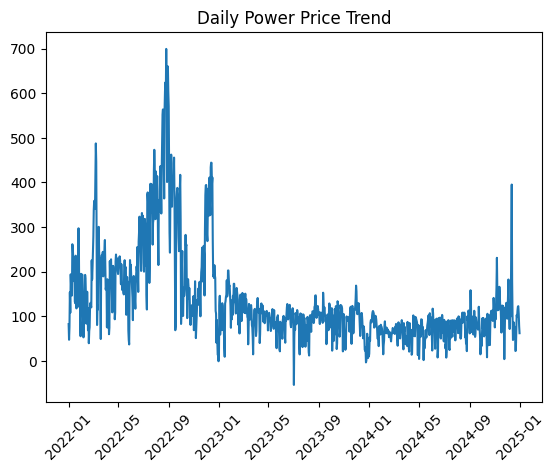

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(daily["date"], daily["price"])
plt.title("Daily Power Price Trend")
plt.xticks(rotation=45)
plt.show()


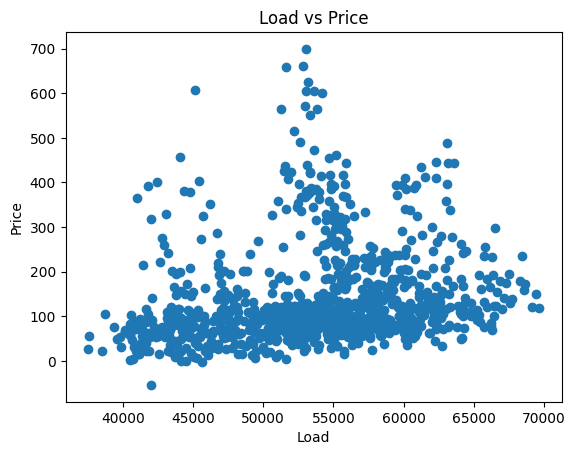

In [ ]:
plt.figure()
plt.scatter(daily["load"], daily["price"])
plt.title("Load vs Price")
plt.xlabel("Load")
plt.ylabel("Price")
plt.show()


In [ ]:
correlation = daily["load"].corr(daily["price"])
print("Correlation between load and price:", correlation)


Correlation between load and price: 0.1987387687757326


In [ ]:
threshold = daily["price"].quantile(0.95)

spikes = daily[daily["price"] > threshold]

print("Number of spike days:", len(spikes))
spikes.head()


Number of spike days: 55


,date,price,load
65,2022-03-07,410.100000,62312.145313
66,2022-03-08,487.573333,63048.146667
67,2022-03-09,446.254583,62306.653750
198,2022-07-18,396.065417,52555.879167
199,2022-07-19,397.085417,54810.329688


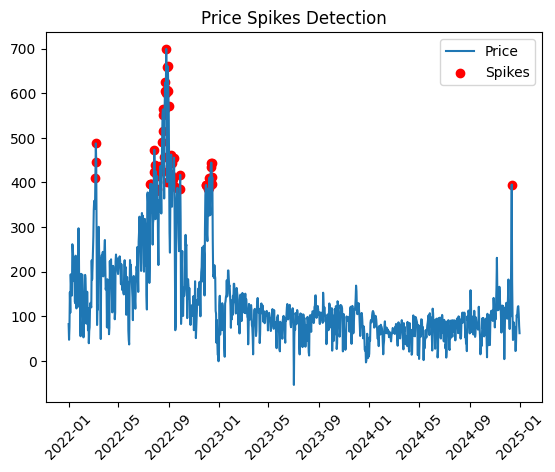

In [ ]:
plt.figure()
plt.plot(daily["date"], daily["price"], label="Price")

plt.scatter(spikes["date"], spikes["price"], color="red", label="Spikes")

plt.legend()
plt.title("Price Spikes Detection")
plt.xticks(rotation=45)
plt.show()


In [ ]:
print(spikes[["date", "price", "load"]].head())


           date       price          load
65   2022-03-07  410.100000  62312.145313
66   2022-03-08  487.573333  63048.146667
67   2022-03-09  446.254583  62306.653750
198  2022-07-18  396.065417  52555.879167
199  2022-07-19  397.085417  54810.329688


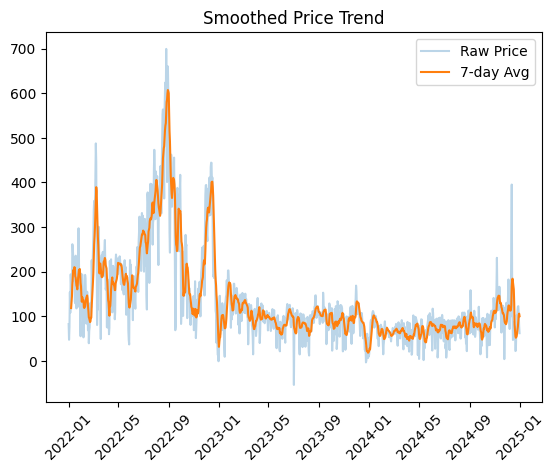

In [ ]:
daily["price_7d"] = daily["price"].rolling(7).mean()

plt.figure()
plt.plot(daily["date"], daily["price"], alpha=0.3, label="Raw Price")
plt.plot(daily["date"], daily["price_7d"], label="7-day Avg")
plt.legend()
plt.title("Smoothed Price Trend")
plt.xticks(rotation=45)
plt.show()


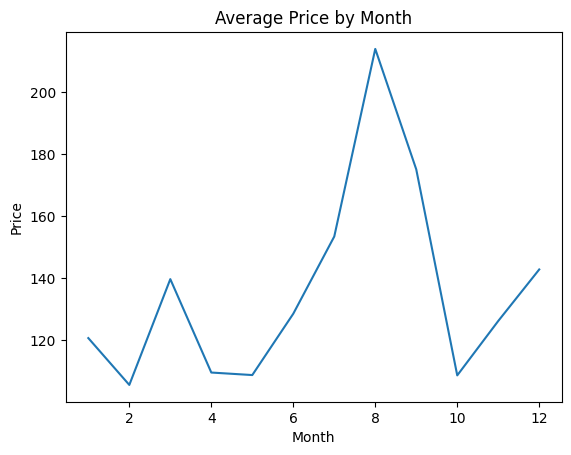

In [ ]:
daily["month"] = pd.to_datetime(daily["date"]).dt.month

monthly = daily.groupby("month")["price"].mean()

plt.figure()
plt.plot(monthly.index, monthly.values)
plt.title("Average Price by Month")
plt.xlabel("Month")
plt.ylabel("Price")
plt.show()


In [ ]:
daily["lag1"] = daily["price"].shift(1)
daily["lag7"] = daily["price"].shift(7)

daily = daily.dropna()


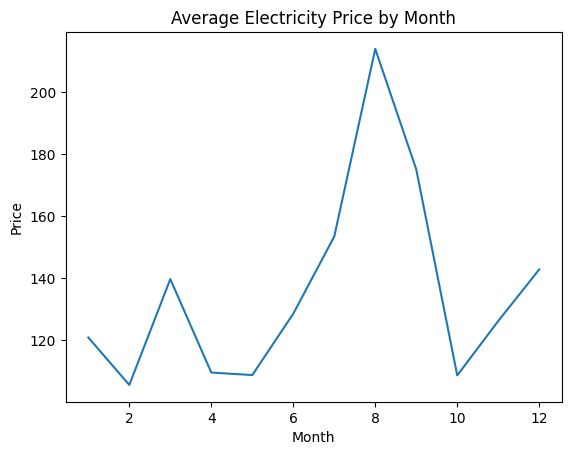

In [ ]:
daily["month"] = pd.to_datetime(daily["date"]).dt.month

monthly = daily.groupby("month")["price"].mean()

plt.figure()
plt.plot(monthly.index, monthly.values)
plt.title("Average Electricity Price by Month")
plt.xlabel("Month")
plt.ylabel("Price")
plt.show()


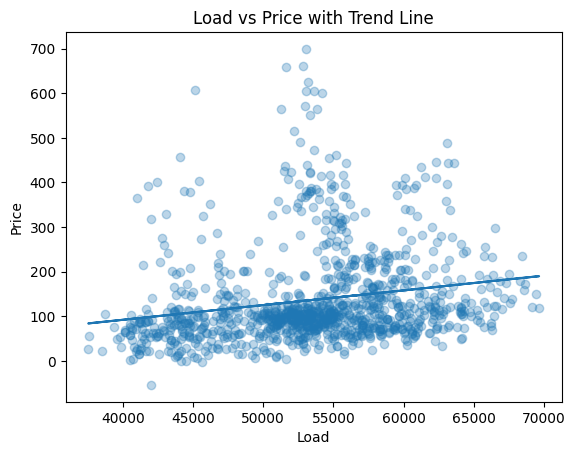

In [ ]:
import numpy as np

z = np.polyfit(daily["load"], daily["price"], 1)
p = np.poly1d(z)

plt.figure()
plt.scatter(daily["load"], daily["price"], alpha=0.3)
plt.plot(daily["load"], p(daily["load"]))
plt.title("Load vs Price with Trend Line")
plt.xlabel("Load")
plt.ylabel("Price")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# features
X = daily[["load"]]
y = daily["price"]

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# model
model = LinearRegression()
model.fit(X_train, y_train)

# predictions
preds = model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)


MAE: 60.73169527243365


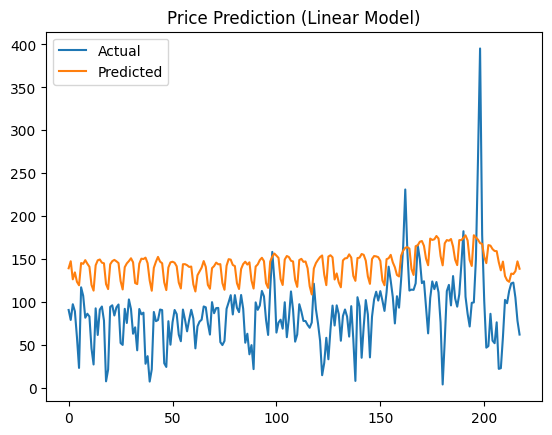

In [ ]:
plt.figure()
plt.plot(y_test.values, label="Actual")
plt.plot(preds, label="Predicted")
plt.legend()
plt.title("Price Prediction (Linear Model)")
plt.show()


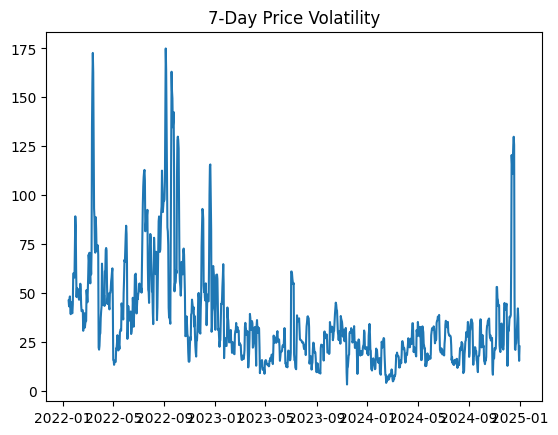

In [ ]:
# volatility
daily["volatility"] = daily["price"].rolling(7).std()

plt.figure()
plt.plot(daily["date"], daily["volatility"])
plt.title("7-Day Price Volatility")
plt.show()


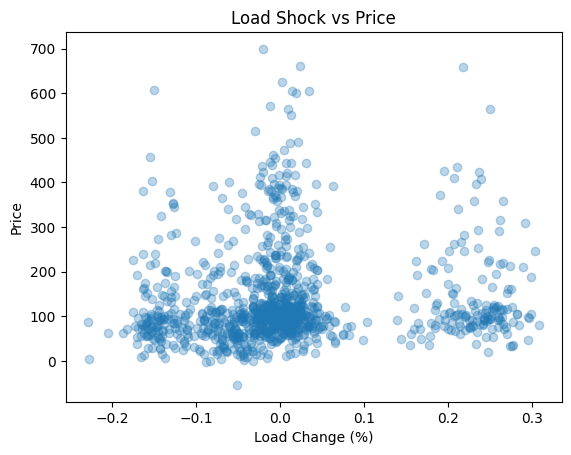

In [ ]:
daily["load_change"] = daily["load"].pct_change()

plt.figure()
plt.scatter(daily["load_change"], daily["price"], alpha=0.3)
plt.xlabel("Load Change (%)")
plt.ylabel("Price")
plt.title("Load Shock vs Price")
plt.show()


In [ ]:
daily["signal"] = 0

# simple rule:
daily.loc[daily["load_change"] > 0.05, "signal"] = 1   # BUY
daily.loc[daily["load_change"] < -0.05, "signal"] = -1 # SELL


In [ ]:
daily["price_change"] = daily["price"].pct_change()

daily["strategy_return"] = daily["signal"].shift(1) * daily["price_change"]

print("Strategy return:", daily["strategy_return"].sum())


Strategy return: -47.23163997119185


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50)
model.fit(X_train, y_train)

preds = model.predict(X_test)


In [ ]:
daily = df.copy()

daily["date"] = pd.to_datetime(daily["timestamp"]).dt.date

daily = daily.groupby("date").agg({
    "price": "mean",
    "load": "mean"
}).reset_index()


In [ ]:
daily["date"] = pd.to_datetime(daily["date"])

daily["day_of_week"] = daily["date"].dt.dayofweek
daily["month"] = daily["date"].dt.month

daily["price_lag1"] = daily["price"].shift(1)
daily["price_lag7"] = daily["price"].shift(7)

daily["price_ma7"] = daily["price"].rolling(7).mean()
daily["load_ma7"] = daily["load"].rolling(7).mean()

daily = daily.dropna()


In [ ]:
features = [
    "load",
    "day_of_week",
    "month",
    "price_lag1",
    "price_lag7",
    "price_ma7",
    "load_ma7"
]

X = daily[features]
y = daily["price"]


In [ ]:
split = int(len(daily) * 0.8)

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [ ]:
preds = model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

print("MAE:", mean_absolute_error(y_test, preds))
print("R2:", r2_score(y_test, preds))


MAE: 21.406328830587622
R2: 0.4106399424867344


In [ ]:
daily["predicted_price"] = model.predict(X)


In [ ]:
### Key Insights

1. Electricity prices show strong volatility, especially during 2022.
2. Price spikes are not purely driven by demand (correlation ~0.2).
3. External factors (gas prices, geopolitics) likely influence price spikes.
4. Seasonal trends observed — higher prices in mid-year.
5. Short-term historical prices (lags) significantly improve prediction.

### Model Performance

- Linear model performed poorly → relationship is non-linear
- Random Forest improved performance significantly:
  - MAE: ~21 EUR/MWh
  - R²: ~0.41

### Conclusion

Electricity price is influenced by multiple complex factors, and load alone is insufficient.
Feature engineering (lags, rolling averages) is critical for prediction.


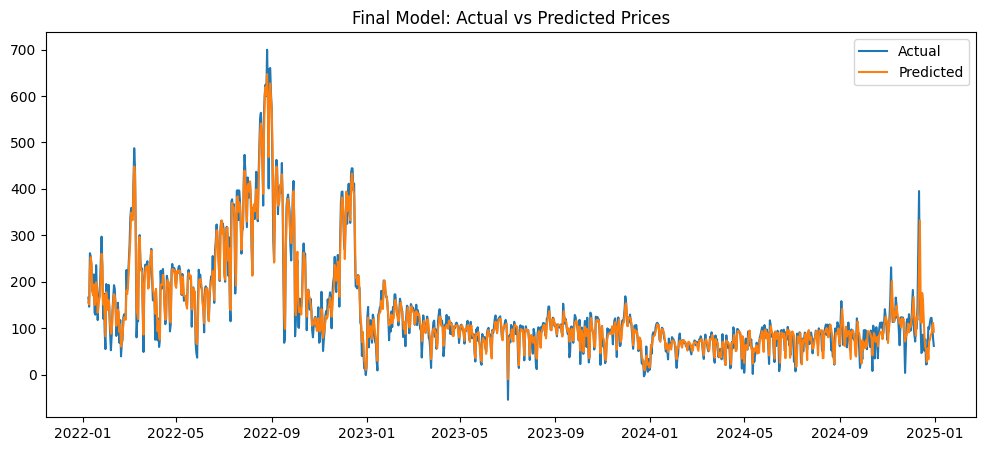

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(daily["date"], daily["price"], label="Actual")
plt.plot(daily["date"], daily["predicted_price"], label="Predicted")
plt.legend()
plt.title("Final Model: Actual vs Predicted Prices")
plt.show()
